In [1]:
#from astropy.io import ascii
from astroquery.vizier import Vizier
import os
import pandas as pd
import numpy as np

In [ ]:
# Declerations
zf_catalogue = Vizier(catalog='J/ApJ/830/51', columns=['all'], row_limit=-1).get_catalogs('J/ApJ/830/51')
# wasteful to load all of these tables just to use 2 of em

failed_cdfs_dir = os.path.join('..', 'ZFOURGE', 'data', 'cdfs_cigale_failed_ids') # List of failed galaxies by ZFOURGE ID, seperated by \n
#cdfs_dir = os.path.join('..', 'ZFOURGE', 'data', 'cdfs', 'cdfs.v1.6.11.cat') # ZFOURGE CDFS field photometry data
#cdfs_z_dir = os.path.join('..', 'ZFOURGE', 'data', 'cdfs', 'cdfs.v1.6.9.zout') # Output of Eazy, contains redshift data
filter_match = os.path.join('..', 'ZFOURGE', 'data', 'filter_match_table') # An ASCII table with the ZFOURGE filter name in 1st collumn, and filter transmission file name in 2nd col.
output_dir = os.path.join('..', 'ZFOURGE', 'data', 'working_sample2') # Directory for output ascii table

output_failed_galaxies = True # True: will output all galaxies with ids found in list of failed ids.
only_zfourge_filters = False # True: will only use j1, j2, j3, hs, hl, and ks bands. False: uses most avalbile bands
add_random_successful_galaxy = False # True: will add a randomly selected successful galaxy to output
use_z_spec = True # True: will replace redshift in output with z_spec if value != -99.0
manual_galaxy_ids = [] # Optional list of manually selected galaxy ids to add to output. Expected to be non-failed galxies.

In [3]:
def Read_Ascii(dir, index='id'):
    # Returns dataframe from local table
    
    with open(dir, 'r') as table:
        header = table.readline()[1:].split() # slice to skip over # character
        #header = [''.join([ch if ch.isalpha() else '' for ch in elem]) for elem in header] # removes non-alphabt characters such as _
    return pd.read_csv(dir, names=header, encoding='ascii', comment='#', delim_whitespace=True, index_col=index)

In [4]:
# Loads failed galaxy id list and reads all cdfs data
if output_failed_galaxies == True:
    with open(failed_cdfs_dir, 'r') as failed_ids:
        failed_cdfs = [int(id) for id in failed_ids.readlines()[1:]] # skip header row

cdfs_table = zf_catalogue[0].to_pandas(index='Seq')

In [6]:
# Adds failed galxies when true
if output_failed_galaxies == True:
    failed_cdfs_table = cdfs_table[cdfs_table.index.isin(failed_cdfs)]
else:
    failed_cdfs_table = pd.DataFrame()
        
# Adds manually selected galaxies when provided
failed_cdfs_table = pd.concat([failed_cdfs_table, 
                               cdfs_table[cdfs_table.index.isin(manual_galaxy_ids)]])
if any(item in failed_cdfs for item in manual_galaxy_ids):
    print("Manually selected galaxy is in list of galaxies. This galaxy may appear twice in output.")

# Adds random galaxy not already included when true
if add_random_successful_galaxy == True:
    i = int(np.random.rand()*len(cdfs_table)) # i <- [0, 30911)
    while i in failed_cdfs:
        i = int(np.random.rand()*len(cdfs_table))
    failed_cdfs_table = pd.concat([failed_cdfs_table, cdfs_table.loc[i:i]])

failed_cdfs_table.sort_index(inplace=True)

In [7]:
# Access and parse redshift data
cdfs_z_table = zf_catalogue[3].to_pandas(index='Seq')
failed_cdfs_z_table = cdfs_z_table[cdfs_z_table.index.isin(failed_cdfs_table.index)]

In [8]:
# Defines output table and adds id and photometric redshift column
output = pd.concat([failed_cdfs_table, failed_cdfs_z_table], axis=1)
output = output['zpk'] # not very efficient to delete most of the dataframe just to add everything back later

In [9]:
# Reads filter matching table
filter_table = Read_Ascii(filter_match, index=None)
# Use ZFOURGE column for manually downloaded, use VIZIER for astroquery data

In [10]:
# Cell adds FourStar filters only
if only_zfourge_filters == True:
    output = pd.concat([output, failed_cdfs_table.loc[:, filter_table.loc[13:24, 'VIZIER']]], axis=1)
    # 13 to 24 are the zfourge filters in the match table

In [11]:
# Cell adds (mostly) all filters
if only_zfourge_filters == False:
    output = pd.concat([output, failed_cdfs_table.loc[:, filter_table.loc[2: , 'VIZIER']]], axis=1)

In [12]:
# Renames output to CIGALE format using matching table
output.rename(columns={zf : cig for zf, cig in zip(filter_table['VIZIER'], filter_table['CIGALE'])}, inplace=True)

In [13]:
# replaces photo z with z_spec if avalible, and sets null values to np.nan
output.replace(-99.0, np.nan, inplace=True)
output['redshift'].fillna(cdfs_z_table[filter_table.at[1, 'VIZIER']], inplace=True)

In [14]:
# Convert units of flux to mJy, and sets -99 to NaN again
output.replace(-99.0, np.nan, inplace=True) # in case there were -99.0 values in z_spec that got filled in
output.iloc[:, 2:] = output.iloc[:, 2:] * 0.3631 / 1000 # conversion form 0.3631 uJy to mJy

In [15]:
# Write output to output_dir file
output.to_csv(output_dir, sep=' ', na_rep='nan')

In [16]:
output

,redshift,hst-ACS_update_sep07-wfc_f435w_t81,hst-ACS_update_sep07-wfc_f435w_t81_err,hst-ACS_update_sep07-wfc_f775w_t81,hst-ACS_update_sep07-wfc_f775w_t81_err,ESO-VIMOS-R,ESO-VIMOS-R_err,ESO-vimos_u,ESO-vimos_u_err,hst-ACS_update_sep07-wfc_f606w_t81,...,WIRCam-cfh8302_Ks,WIRCam-cfh8302_Ks_err,IRAC-irac_tr1_2004-08-09,IRAC-irac_tr1_2004-08-09_err,IRAC-irac_tr2_2004-08-09,IRAC-irac_tr2_2004-08-09_err,IRAC-irac_tr3_2004-08-09,IRAC-irac_tr3_2004-08-09_err,IRAC-irac_tr4_2004-08-09,IRAC-irac_tr4_2004-08-09_err
Seq,,,,,,,,,,,,,,,,,,,,,


<Axes: ylabel='Frequency'>

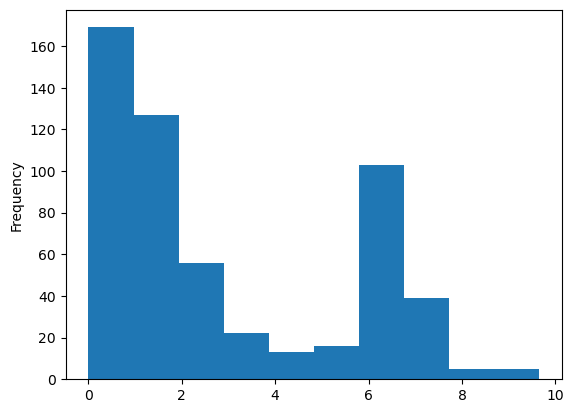

In [ ]:
# Redshift histogram
output['redshift'].plot.hist()

In [ ]:
# Summary statistics of FourStar filters
output.describe().loc[:, 'FOURSTAR-Hshort_cam_optics_sky' : 'FOURSTAR-Ks_cam_optics_sky_err']

,FOURSTAR-Hshort_cam_optics_sky,FOURSTAR-Hshort_cam_optics_sky_err,FOURSTAR-Hlong_cam_optics_sky,FOURSTAR-Hlong_cam_optics_sky_err,FOURSTAR-J1_cam_optics_sky,FOURSTAR-J1_cam_optics_sky_err,FOURSTAR-J2_cam_optics_sky,FOURSTAR-J2_cam_optics_sky_err,FOURSTAR-J3_cam_optics_sky,FOURSTAR-J3_cam_optics_sky_err,FOURSTAR-Ks_cam_optics_sky,FOURSTAR-Ks_cam_optics_sky_err
count,189.000000,189.000000,180.000000,180.000000,195.000000,195.000000,196.000000,196.000000,189.000000,189.000000,196.000000,196.000000
mean,0.231529,0.000166,0.226834,0.000149,0.165297,0.000103,0.148877,0.000095,0.208893,0.000108,0.153048,0.000232
std,1.216169,0.000186,1.138966,0.000179,0.808566,0.000128,0.696610,0.000105,1.065918,0.000135,0.776350,0.000238
min,-0.000917,0.000035,-0.000647,0.000037,-0.000206,0.000019,-0.000184,0.000018,-0.000588,0.000022,-0.000755,0.000047
25%,0.000073,0.000092,0.000034,0.000096,0.000049,0.000050,0.000055,0.000049,0.000054,0.000057,0.000106,0.000123
50%,0.000204,0.000106,0.000194,0.000108,0.000158,0.000057,0.000176,0.000057,0.000166,0.000066,0.000273,0.000145
75%,0.002962,0.000142,0.002827,0.000136,0.002605,0.000081,0.002747,0.000081,0.002918,0.000089,0.003524,0.000200
max,11.043411,0.001163,9.862954,0.001696,7.079942,0.000859,5.978877,0.000616,9.387478,0.000949,6.972755,0.001414


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(initial_strategy='most_frequent')
imputed = pd.DataFrame(imputer.fit_transform(output), columns=output.columns)
imputed

/Users/colin/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,redshift,hst-ACS_update_sep07-wfc_f435w_t81,hst-ACS_update_sep07-wfc_f435w_t81_err,hst-ACS_update_sep07-wfc_f775w_t81,hst-ACS_update_sep07-wfc_f775w_t81_err,ESO-VIMOS-R,ESO-VIMOS-R_err,ESO-vimos_u,ESO-vimos_u_err,hst-ACS_update_sep07-wfc_f606w_t81,...,WIRCam-cfh8302_Ks,WIRCam-cfh8302_Ks_err,IRAC-irac_tr1_2004-08-09,IRAC-irac_tr1_2004-08-09_err,IRAC-irac_tr2_2004-08-09,IRAC-irac_tr2_2004-08-09_err,IRAC-irac_tr3_2004-08-09,IRAC-irac_tr3_2004-08-09_err,IRAC-irac_tr4_2004-08-09,IRAC-irac_tr4_2004-08-09_err
0,3.8120,-1.310097e+96,-1.948854e+89,6.364227e+92,3.243818e+89,-8.842610e+93,-2.315426e+92,0.205989,0.000037,5.892823e+92,...,0.466232,0.000716,3.333650e+83,-6.396739e+79,3.915200e+83,2.024821e+80,7.564290e+83,6.852903e+93,2.407590e+94,1.863896e+93
1,7.3259,-2.928893e+94,-4.356918e+87,1.422806e+91,7.251980e+87,-1.976881e+92,-5.176437e+90,0.000923,0.000007,1.317418e+91,...,0.000008,0.000142,7.452812e+81,-1.430075e+78,8.752942e+81,4.526753e+78,1.691096e+82,1.532056e+92,5.382484e+92,4.166984e+91
2,0.3429,4.403993e+01,1.603332e-05,-7.623985e-03,2.885297e-05,5.116369e-04,1.260647e-04,-0.000030,0.000016,4.578115e-03,...,0.003765,0.000219,1.260872e-03,1.162574e-04,-8.893953e-04,1.304146e-04,-1.492261e-01,-1.492260e-01,-1.492261e-01,-1.492260e-01
3,0.9579,3.768659e+01,2.166842e-05,3.045567e-04,4.497825e-05,2.373911e-04,2.471622e-05,0.000134,0.000006,1.223173e-04,...,0.000618,0.000105,6.473964e-04,5.428708e-05,4.690671e-04,6.008942e-05,-7.227070e-02,-7.227063e-02,1.165682e-03,2.718257e-03
4,1.6893,4.060087e+02,1.857960e-05,1.714163e-03,6.114664e-05,-1.587172e-04,2.953710e-04,-0.000085,0.000060,4.468363e-04,...,0.013242,0.001112,1.203775e-02,4.509992e-04,1.486343e-02,7.844812e-04,-7.954795e-01,-7.954780e-01,9.192603e-03,9.254820e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,0.0050,3.407355e+02,3.662569e-05,1.875776e-01,-1.915174e-05,4.407998e-02,2.203999e-03,0.005590,0.000006,1.390386e-01,...,2.761574,0.000116,1.702998e+00,7.373472e-05,1.117611e+00,8.143244e-05,-5.618900e-02,8.565783e-04,-9.527926e-02,6.764299e-04
551,3.0410,3.266898e+01,2.249542e-05,4.358340e-03,4.052648e-05,2.381969e-02,1.190983e-03,0.005854,0.000011,1.135867e-02,...,0.026923,0.000221,1.435277e-02,1.144854e-04,1.534570e-02,9.875594e-05,-1.198099e-02,2.160863e-03,3.310455e-04,1.228001e-03
552,2.8805,-6.085702e-01,2.023220e-05,-3.401372e-04,3.806123e-05,1.107662e-03,5.538364e-05,0.000475,0.000007,2.379166e-04,...,0.000815,0.000133,7.779454e-04,5.852446e-05,-1.409830e-05,5.049269e-05,-4.544051e-03,3.565130e-03,1.395742e-03,8.961925e-04
553,6.9235,6.743733e+02,-3.091401e-03,7.953785e+00,-5.057360e-03,5.630737e-05,5.983888e-06,-0.000006,0.000006,-7.836145e+00,...,-4.673603,-0.007241,1.816891e-03,5.645842e-05,1.103544e-03,6.026371e-05,9.942695e-04,7.355716e-04,1.125109e-03,5.670387e-04


In [ ]:
# Summary statistics of imputed data
imputed.describe().loc[:, 'FOURSTAR-Hshort_cam_optics_sky' : 'FOURSTAR-Ks_cam_optics_sky_err']

,FOURSTAR-Hshort_cam_optics_sky,FOURSTAR-Hshort_cam_optics_sky_err,FOURSTAR-Hlong_cam_optics_sky,FOURSTAR-Hlong_cam_optics_sky_err,FOURSTAR-J1_cam_optics_sky,FOURSTAR-J1_cam_optics_sky_err,FOURSTAR-J2_cam_optics_sky,FOURSTAR-J2_cam_optics_sky_err,FOURSTAR-J3_cam_optics_sky,FOURSTAR-J3_cam_optics_sky_err,FOURSTAR-Ks_cam_optics_sky,FOURSTAR-Ks_cam_optics_sky_err
count,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.550000e+02
mean,-6.031909e+89,-3.151949e+87,-2.954649e+89,-1.216474e+88,3.634144e+89,1.645293e+86,-4.748010e+90,-1.736303e+87,4.345872e+90,-6.594101e+87,9.088497e+89,-2.486375e+88
std,1.390241e+91,7.264646e+88,6.809905e+90,2.803742e+89,8.376012e+90,3.792087e+87,1.094326e+92,4.001849e+88,1.001641e+92,1.519815e+89,2.094726e+91,5.730623e+89
min,-3.274504e+92,-1.711079e+90,-1.603971e+92,-6.603795e+90,-7.241724e-01,-9.046175e+07,-2.577522e+93,-9.425756e+89,-8.494517e+08,-3.579697e+90,-1.011888e+10,-1.349762e+91
25%,-2.153681e-02,1.190318e-04,-5.408822e-03,1.213444e-04,-1.724206e-02,6.781437e-05,-1.669040e-02,6.691933e-05,-1.787332e-02,7.487848e-05,-1.856790e-04,1.629284e-04
50%,-2.467628e-04,2.108166e-04,8.624351e-05,2.216908e-04,6.810558e-05,2.363479e-04,2.237742e-05,1.580542e-04,8.421814e-05,2.799058e-04,5.478543e-04,4.742071e-04
75%,2.676398e-04,2.305343e-04,5.006528e-04,2.516665e-04,7.714037e-04,2.935185e-04,4.543307e-04,1.866979e-04,7.184351e-04,3.271168e-04,1.857938e-03,5.449961e-04
max,1.104341e+01,1.163387e-03,9.862954e+00,4.682392e-03,1.972844e+92,8.931694e+88,5.717524e+09,1.663158e-03,2.359216e+93,1.853935e-03,4.933814e+92,3.371258e-03


?!!?!!?!?!